In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from bd_datagen import generate_collocation_points, generate_interface_collocation_points
from bd_loss_fns import pde_loss, bc_loss, interface_loss, flexural_rigidity, normalise, denormalise
from bd_beamdoublenet import BeamDoubleNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


Total PDE points for Beam 1: 2455
Total PDE points for Beam 2: 2545


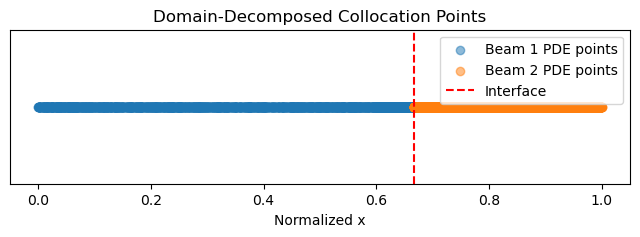

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assume the following functions are defined elsewhere:
# def generate_collocation_points(n, x_ranges): ...
# def normalise(x, xmin, xmax): ...
# def generate_interface_collocation_points(n, n_interface, x_ranges, interface_x, interface_width): ...


# --- Your Data Generation Parameters ---
n_collocation = 2000
n_interface = 1000
x_ranges = [(0,2), (2,3)]
interface_x = 2.0
interface_width = 0.1
xmin, xmax = 0.0, 3.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Generate Uniform Collocation Points for Each Domain

x1_uniform_np, x2_uniform_np = generate_collocation_points(n_collocation, x_ranges)


#Generate and Split Adaptive Collocation Points
# `generate_interface_collocation_points` is a list, and `[-1]` gets the last element.
interface_points_np = generate_interface_collocation_points(0, n_interface, x_ranges, interface_x, interface_width)[-1]

# Now, we split these points into their respective domains
interface_points_norm = normalise(interface_points_np, xmin, xmax)
interface_x_norm = normalise(interface_x, xmin, xmax)

x1_adaptive_np = interface_points_norm[interface_points_norm < interface_x_norm]
x2_adaptive_np = interface_points_norm[interface_points_norm >= interface_x_norm]


# Combine Uniform and Adaptive Points for Each Domain ---

x1_pde_combined_np = np.concatenate((normalise(x1_uniform_np, xmin, xmax), x1_adaptive_np.reshape(-1, 1)))
x2_pde_combined_np = np.concatenate((normalise(x2_uniform_np, xmin, xmax), x2_adaptive_np.reshape(-1, 1)))


# Convert to PyTorch Tensors and Finalize 
x1_pde_torch = torch.from_numpy(x1_pde_combined_np).to(torch.float32).to(device)
x2_pde_torch = torch.from_numpy(x2_pde_combined_np).to(torch.float32).to(device)

# Shuffle them to ensure they are randomly ordered (useful for minibatching)
shuffled_indices_1 = torch.randperm(len(x1_pde_torch))
x1_pde_torch = x1_pde_torch[shuffled_indices_1]

shuffled_indices_2 = torch.randperm(len(x2_pde_torch))
x2_pde_torch = x2_pde_torch[shuffled_indices_2]

# Ensure final tensors require gradients.
x1_pde_torch.requires_grad_(True)
x2_pde_torch.requires_grad_(True)

print(f"Total PDE points for Beam 1: {len(x1_pde_torch)}")
print(f"Total PDE points for Beam 2: {len(x2_pde_torch)}")

# VISUALISATION
x1_pde_combined_flat = x1_pde_combined_np.flatten()
x2_pde_combined_flat = x2_pde_combined_np.flatten()
plt.figure(figsize=(8, 2))
plt.scatter(x1_pde_combined_flat, np.zeros_like(x1_pde_combined_flat), alpha=0.5, label='Beam 1 PDE points')
plt.scatter(x2_pde_combined_flat, np.zeros_like(x2_pde_combined_flat), alpha=0.5, label='Beam 2 PDE points')
plt.axvline(interface_x_norm, color='r', linestyle='--', label='Interface')
plt.xlabel('Normalized x')
plt.yticks([])
plt.title('Domain-Decomposed Collocation Points')
plt.legend()
plt.show()


In [3]:
# Instantiate the models

n_units=40
n_layers=4
pde_weight=1.0
bc_weight=1e-2
if_weight=1e-1
if_cont_weight = 1.0 
if_shear_weight = 1e-4


model_beam1 = BeamDoubleNet(
    input_dim=1, output_dim=2,
    n_units=n_units, n_layers=n_layers,
    pde_weight=pde_weight, bc_weight=bc_weight, if_weight=if_weight,
    if_cont_weight=if_cont_weight, if_shear_weight=if_shear_weight,
).to(device)

model_beam2 = BeamDoubleNet(
    input_dim=1, output_dim=2,
    n_units=n_units, n_layers=n_layers,
    pde_weight=pde_weight, bc_weight=bc_weight, if_weight=if_weight,
    if_cont_weight=if_cont_weight, if_shear_weight=if_shear_weight,
).to(device)


# Set up the optimizer (a single optimizer to update the params of BOTH models)

optimizer = torch.optim.Adam(
    list(model_beam1.parameters()) + list(model_beam2.parameters()),
    lr=0.001
)

Epoch 0: Total Loss 3.6737e+06 | PDE 2.7155e-02 | BC 7.7601e+06 | IF 3.5961e+07
Epoch 200: Total Loss 1.1285e+02 | PDE 7.6769e-05 | BC 1.1263e+04 | IF 2.1884e+00
Epoch 400: Total Loss 7.1707e-01 | PDE 1.1103e-04 | BC 7.1554e+01 | IF 1.4243e-02
Epoch 600: Total Loss 5.3673e-04 | PDE 9.0490e-05 | BC 4.4420e-02 | IF 2.0391e-05
Epoch 800: Total Loss 7.9454e-05 | PDE 7.4097e-05 | BC 4.5258e-04 | IF 8.3073e-06
Epoch 1000: Total Loss 7.0032e-05 | PDE 6.4601e-05 | BC 4.5722e-04 | IF 8.5815e-06
Epoch 1200: Total Loss 6.5358e-05 | PDE 5.9246e-05 | BC 5.2439e-04 | IF 8.6804e-06
Epoch 1400: Total Loss 6.2594e-05 | PDE 5.6132e-05 | BC 5.6309e-04 | IF 8.3156e-06
Epoch 1600: Total Loss 6.0673e-05 | PDE 5.4208e-05 | BC 5.7078e-04 | IF 7.5697e-06
Epoch 1800: Total Loss 5.9160e-05 | PDE 5.2928e-05 | BC 5.5515e-04 | IF 6.8001e-06


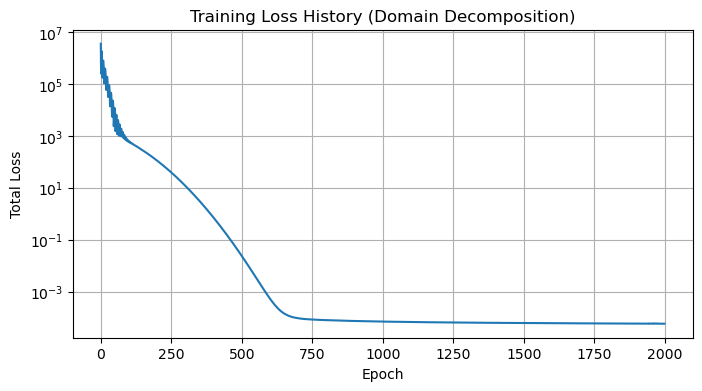

In [4]:
# training loop

losses = []
epochs=2000

for ep in range(epochs):
    # This ensures x_pde_torch has requires_grad=True, even in a notebook
    #x1_pde_torch.requires_grad_(True)
    #x2_pde_torch.requires_grad_(True)          REQUIRED WHEN MINIBATCHING
    optimizer.zero_grad()

    loss_residual = pde_loss(model_beam1, x1_pde_torch, xmin, xmax) + pde_loss(model_beam2, x2_pde_torch, xmin, xmax)
    loss_boundary = bc_loss(model_beam1, model_beam2, xmin, xmax)
    loss_interface = interface_loss(model_beam1, model_beam2, xmin, xmax)

    total_loss = pde_weight*loss_residual + bc_weight*loss_boundary + if_weight*loss_interface

    #backpropagation and optimisation via pytorch
    total_loss.backward()
    optimizer.step()
    losses.append(total_loss.item())

    if ep % int(epochs/10) == 0:
        print(f"Epoch {ep}: Total Loss {total_loss.item():.4e} | "
              f"PDE {loss_residual.item():.4e} | "
              f"BC {loss_boundary.item():.4e} | "
              f"IF {loss_interface.item():.4e}")
        
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss History (Domain Decomposition)')
plt.grid(True)
plt.show()


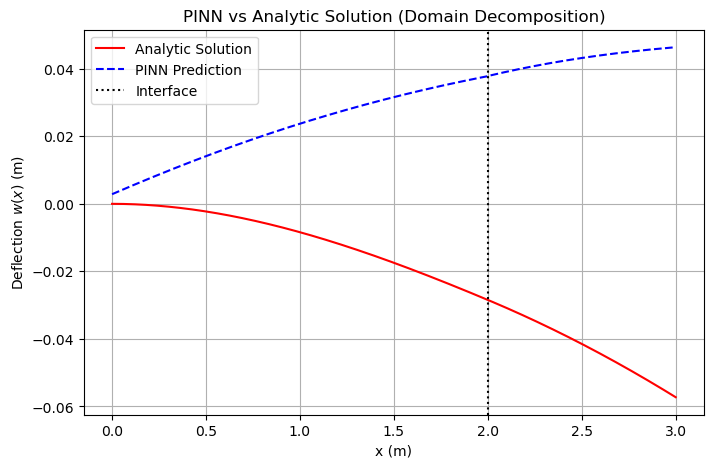

w_at_2m: -0.028455893317255693, w_at_3m: -0.057264201151357726


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1. Beam and material properties
E1, D1 = 210e9, 0.05
E2, D2 = 180e9, 0.04
I1 = np.pi/64 * D1**4
I2 = np.pi/64 * D2**4
EI1 = E1 * I1
EI2 = E2 * I2

# 2. Solve for analytic solution coefficients
A = np.zeros((5, 5))
b = np.zeros(5)

# Unknowns: [c1, d1, a2, b2, c2]
A[0, 0] = 4      # c1
A[0, 1] = 8      # d1
A[0, 2] = -1     # a2
A[0, 3] = -2     # b2
A[0, 4] = -4     # c2
b[0] = 0

A[1, 0] = 4      # c1
A[1, 1] = 12     # d1
A[1, 3] = -1     # b2
A[1, 4] = -4     # c2
b[1] = 0

A[2, 0] = 2*EI1
A[2, 1] = 12*EI1
A[2, 4] = -2*EI2
b[2] = 0

A[3, 1] = -6*EI1
b[3] = -500

A[4, 4] = 2*EI2
b[4] = -250

sol = np.linalg.solve(A, b)
c1, d1, a2, b2, c2 = sol

def w_analytic(x):
    w = np.zeros_like(x)
    mask1 = x < 2
    mask2 = x >= 2
    w[mask1] = c1 * x[mask1]**2 + d1 * x[mask1]**3
    w[mask2] = a2 + b2 * x[mask2] + c2 * x[mask2]**2
    return w

# Generate x values and normalize
x_min, x_max = 0.0, 3.0
x_phys = np.linspace(0, 3, 500)
x_norm = (x_phys - x_min) / (x_max - x_min)

# Evaluate analytic solution
w_true = w_analytic(x_phys)

x_phys = np.linspace(xmin, xmax, 500)
x_norm = normalise(x_phys, xmin, xmax)
x_norm_torch = torch.from_numpy(x_norm.reshape(-1, 1)).to(torch.float32).to(device)

# Use boolean masks to apply the correct model to each segment
interface_norm_val = normalise(interface_x, xmin, xmax)
mask1 = x_norm < interface_norm_val
mask2 = x_norm >= interface_norm_val

w_pinn = np.zeros_like(x_phys)

# Set models to evaluation mode and get predictions
model_beam1.eval()
model_beam2.eval()
with torch.no_grad():
    w_pinn[mask1] = model_beam1(x_norm_torch[mask1]).cpu().numpy()[:, 0].flatten()
    w_pinn[mask2] = model_beam2(x_norm_torch[mask2]).cpu().numpy()[:, 0].flatten()


plt.figure(figsize=(8, 5))
plt.plot(x_phys, w_analytic(x_phys), 'r-', label='Analytic Solution')
plt.plot(x_phys, w_pinn, 'b--', label='PINN Prediction')
plt.axvline(interface_x, color='k', linestyle=':', label='Interface')
plt.xlabel('x (m)')
plt.ylabel('Deflection $w(x)$ (m)')
plt.title('PINN vs Analytic Solution (Domain Decomposition)')
plt.legend()
plt.grid(True)
plt.show()


x_at_2m = 2.0
x_at_3m = 3.0
w_at_2m = w_analytic(np.array([x_at_2m]))[0] # [0] to get the scalar value from the array
w_at_3m = w_analytic(np.array([x_at_3m]))[0]

print(f"w_at_2m: {w_at_2m}, w_at_3m: {w_at_3m}")

In [6]:
class DummyAnalyticModel(nn.Module):
    def __init__(self, c1, d1, a2, b2, c2):
        super().__init__()
        # Store coefficients as parameters so they are moved to device with the model
        self.c1 = nn.Parameter(torch.tensor(c1, dtype=torch.float32), requires_grad=False)
        self.d1 = nn.Parameter(torch.tensor(d1, dtype=torch.float32), requires_grad=False)
        self.a2 = nn.Parameter(torch.tensor(a2, dtype=torch.float32), requires_grad=False)
        self.b2 = nn.Parameter(torch.tensor(b2, dtype=torch.float32), requires_grad=False)
        self.c2 = nn.Parameter(torch.tensor(c2, dtype=torch.float32), requires_grad=False)

    def forward(self, x_norm):
        # Denormalize x_norm back to physical coordinates
        # Use the global xmin, xmax defined in this cell
        x_phys = denormalise(x_norm, xmin, xmax)
        
        # Define the normalized interface position for torch.where
        interface_norm = normalise(interface_x, xmin, xmax)
        
        # Calculate w and v = w'' for each beam segment using PyTorch operations
        # Ensure all operations are on tensors
        w_beam1 = self.c1 * x_phys.pow(2) + self.d1 * x_phys.pow(3)
        w_beam2 = self.a2 + self.b2 * x_phys + self.c2 * x_phys.pow(2)
        
        v_beam1 = 2 * self.c1 + 6 * self.d1 * x_phys
        v_beam2 = 2 * self.c2

        # Combine the results based on the normalized x-coordinate
        w_torch = torch.where(x_norm <= interface_norm, w_beam1, w_beam2)
        v_torch = torch.where(x_norm <= interface_norm, v_beam1, v_beam2)
        
        return torch.cat([w_torch, v_torch], dim=1)


# --- 4. Instantiate the Dummy Models ---
dummy_model_beam1 = DummyAnalyticModel(c1, d1, a2, b2, c2).to(device)
dummy_model_beam2 = DummyAnalyticModel(c1, d1, a2, b2, c2).to(device)
print("Dummy analytic models instantiated.")


# --- 5. Generate Test Points (for the PDE loss evaluation) ---
# These points should span the domains of Beam 1 and Beam 2 respectively.
# Using a simple linspace for testing.
n_test_points = 1000 # More points for a better average
x1_test_np = np.linspace(xmin, interface_x, n_test_points, endpoint=False) # Beam 1 domain
x2_test_np = np.linspace(interface_x, xmax, n_test_points) # Beam 2 domain

# Normalize and convert to torch tensors on the correct device
x1_test_torch = torch.from_numpy(normalise(x1_test_np, xmin, xmax)).reshape(-1, 1).to(torch.float32).to(device)
x2_test_torch = torch.from_numpy(normalise(x2_test_np, xmin, xmax)).reshape(-1, 1).to(torch.float32).to(device)

# Ensure requires_grad=True for the input points to pde_loss
x1_test_torch.requires_grad_(True)
x2_test_torch.requires_grad_(True)
print(f"Generated {len(x1_test_torch)} test points for Beam 1 and {len(x2_test_torch)} for Beam 2.")


# --- 6. Run the Test and Print Results ---
print("\n--- Running PDE Loss Sanity Check ---")
#with torch.no_grad(): # Disable gradient tracking for this evaluation
# PDE loss on Beam 1's domain
loss_pde1_analytic = pde_loss(dummy_model_beam1, x1_test_torch, xmin, xmax)
    
    # PDE loss on Beam 2's domain
loss_pde2_analytic = pde_loss(dummy_model_beam2, x2_test_torch, xmin, xmax)

print(f"Analytic PDE Loss (Beam 1): {loss_pde1_analytic.item():.4e}")
print(f"Analytic PDE Loss (Beam 2): {loss_pde2_analytic.item():.4e}")
print(f"Total Analytic PDE Loss: {(loss_pde1_analytic + loss_pde2_analytic).item():.4e}")


Dummy analytic models instantiated.
Generated 1000 test points for Beam 1 and 1000 for Beam 2.

--- Running PDE Loss Sanity Check ---
Analytic PDE Loss (Beam 1): 9.1745e-19
Analytic PDE Loss (Beam 2): 4.8789e-22
Total Analytic PDE Loss: 9.1794e-19
